In [1]:
import uproot as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from df_utils import * 

In [2]:
run = "run1"
dm_type = "fermion"
mass = "0.05"
target_pot = 1.
signal_pot = {}

signal_correction = { "0.01":0.94903385, "0.02":1.03561568, "0.03":1.02326517, "0.04":1.00641579, 
                     "0.05":1.00650082, "0.06":1.01293082, "0.07":1.07433777, 
                     "0.08":1.10175345, "0.09":1.0415591 , "0.10":1.1014797}


if(dm_type == "fermion"):
    signal_pot = { "0.01":4.49230189e+20, "0.02":3.24986846e+21, "0.03":1.44413783e+22, 
                  "0.04":5.51306150e+22, "0.05":1.74805153e+23, "0.06":5.79056950e+23,
                  "0.07":1.48783150e+24, "0.08":4.41322940e+24, 
                  "0.09":9.92424735e+24, "0.10":2.27414738e+25}

else: 
    signal_pot = { "0.01":8.70545727e+21, "0.02": 9.48797710e+22, "0.03":4.86277630e+23, 
                  "0.04":1.94231827e+24, "0.05":8.19564834e+24, "0.06":2.06542023e+25,
                  "0.07":5.83217654e+25, "0.08":1.54999742e+26, 
                  "0.09":2.94329651e+26, "0.10":5.04481005e+26}


scalings_run1 = { "nu":1.013*1./2.34e21, "dirt":1.026*0.75/1.6e21, "beamoff": 1.03*1.56*0.98}
scalings_run3 = { "nu":1./1.993661e21, "dirt":0.98*0.35/1.020e21, "beamoff": 1.40*2.909}

scalings = {}

if(run == "run1"):
    target_pot = 2.0e20
    scalings = scalings_run1
    pot_label = r'                    $2\times10^{20}$ POT'
else:
    target_pot = 5.0e20
    scalings = scalings_run3
    pot_label = r'                    $5\times10^{20}$ POT'

signal_scaling = signal_correction[mass]*target_pot/signal_pot[mass]
nu_scaling = target_pot*scalings["nu"]
dirt_scaling = target_pot*scalings["dirt"]
offbeam_scaling = scalings["beamoff"]

In [3]:
base_dir = "/home/lmlepin/Desktop/dm_sets/dark_tridents_analysis/" + run + "_samples/" 
plots_dir = "/home/lmlepin/Desktop/Plots_DT_Drive/2023/"

df_signal = pd.read_csv(base_dir + "dt_overlay_"+ mass + "_CNN_scores_8441_steps.csv")
df_nu = pd.read_csv(base_dir + run + "_nu_overlay_CNN_scores_8441_steps.csv")
df_dirt = pd.read_csv(base_dir + run + "_dirt_CNN_scores_8441_steps.csv")
df_offbeam = pd.read_csv(base_dir + run + "_offbeam_CNN_scores_8441_steps.csv")


MC_weight_branch(df_nu)
MC_weight_branch(df_dirt)

In [4]:
def logit_transform(score):
    return np.log(score/(1-score))

def filter_df(df):
    df = df[df['signal_score'] >= 0.5]
    return df 

def GetStatsUncert(df_a, weight_array ):
    (counts_df, bins_df) = np.histogram(df_a['signal_score'], bins = my_custom_bins, weights=np.square(weight_array))
    return counts_df 

Showing results for: run1
Number of dark tridents M_A=0.05 :11.34986230288074
Number of neutrinos: 65.40089359222294
Number of dirt: 12.328569191255704
Number of beam-off: 85.031856


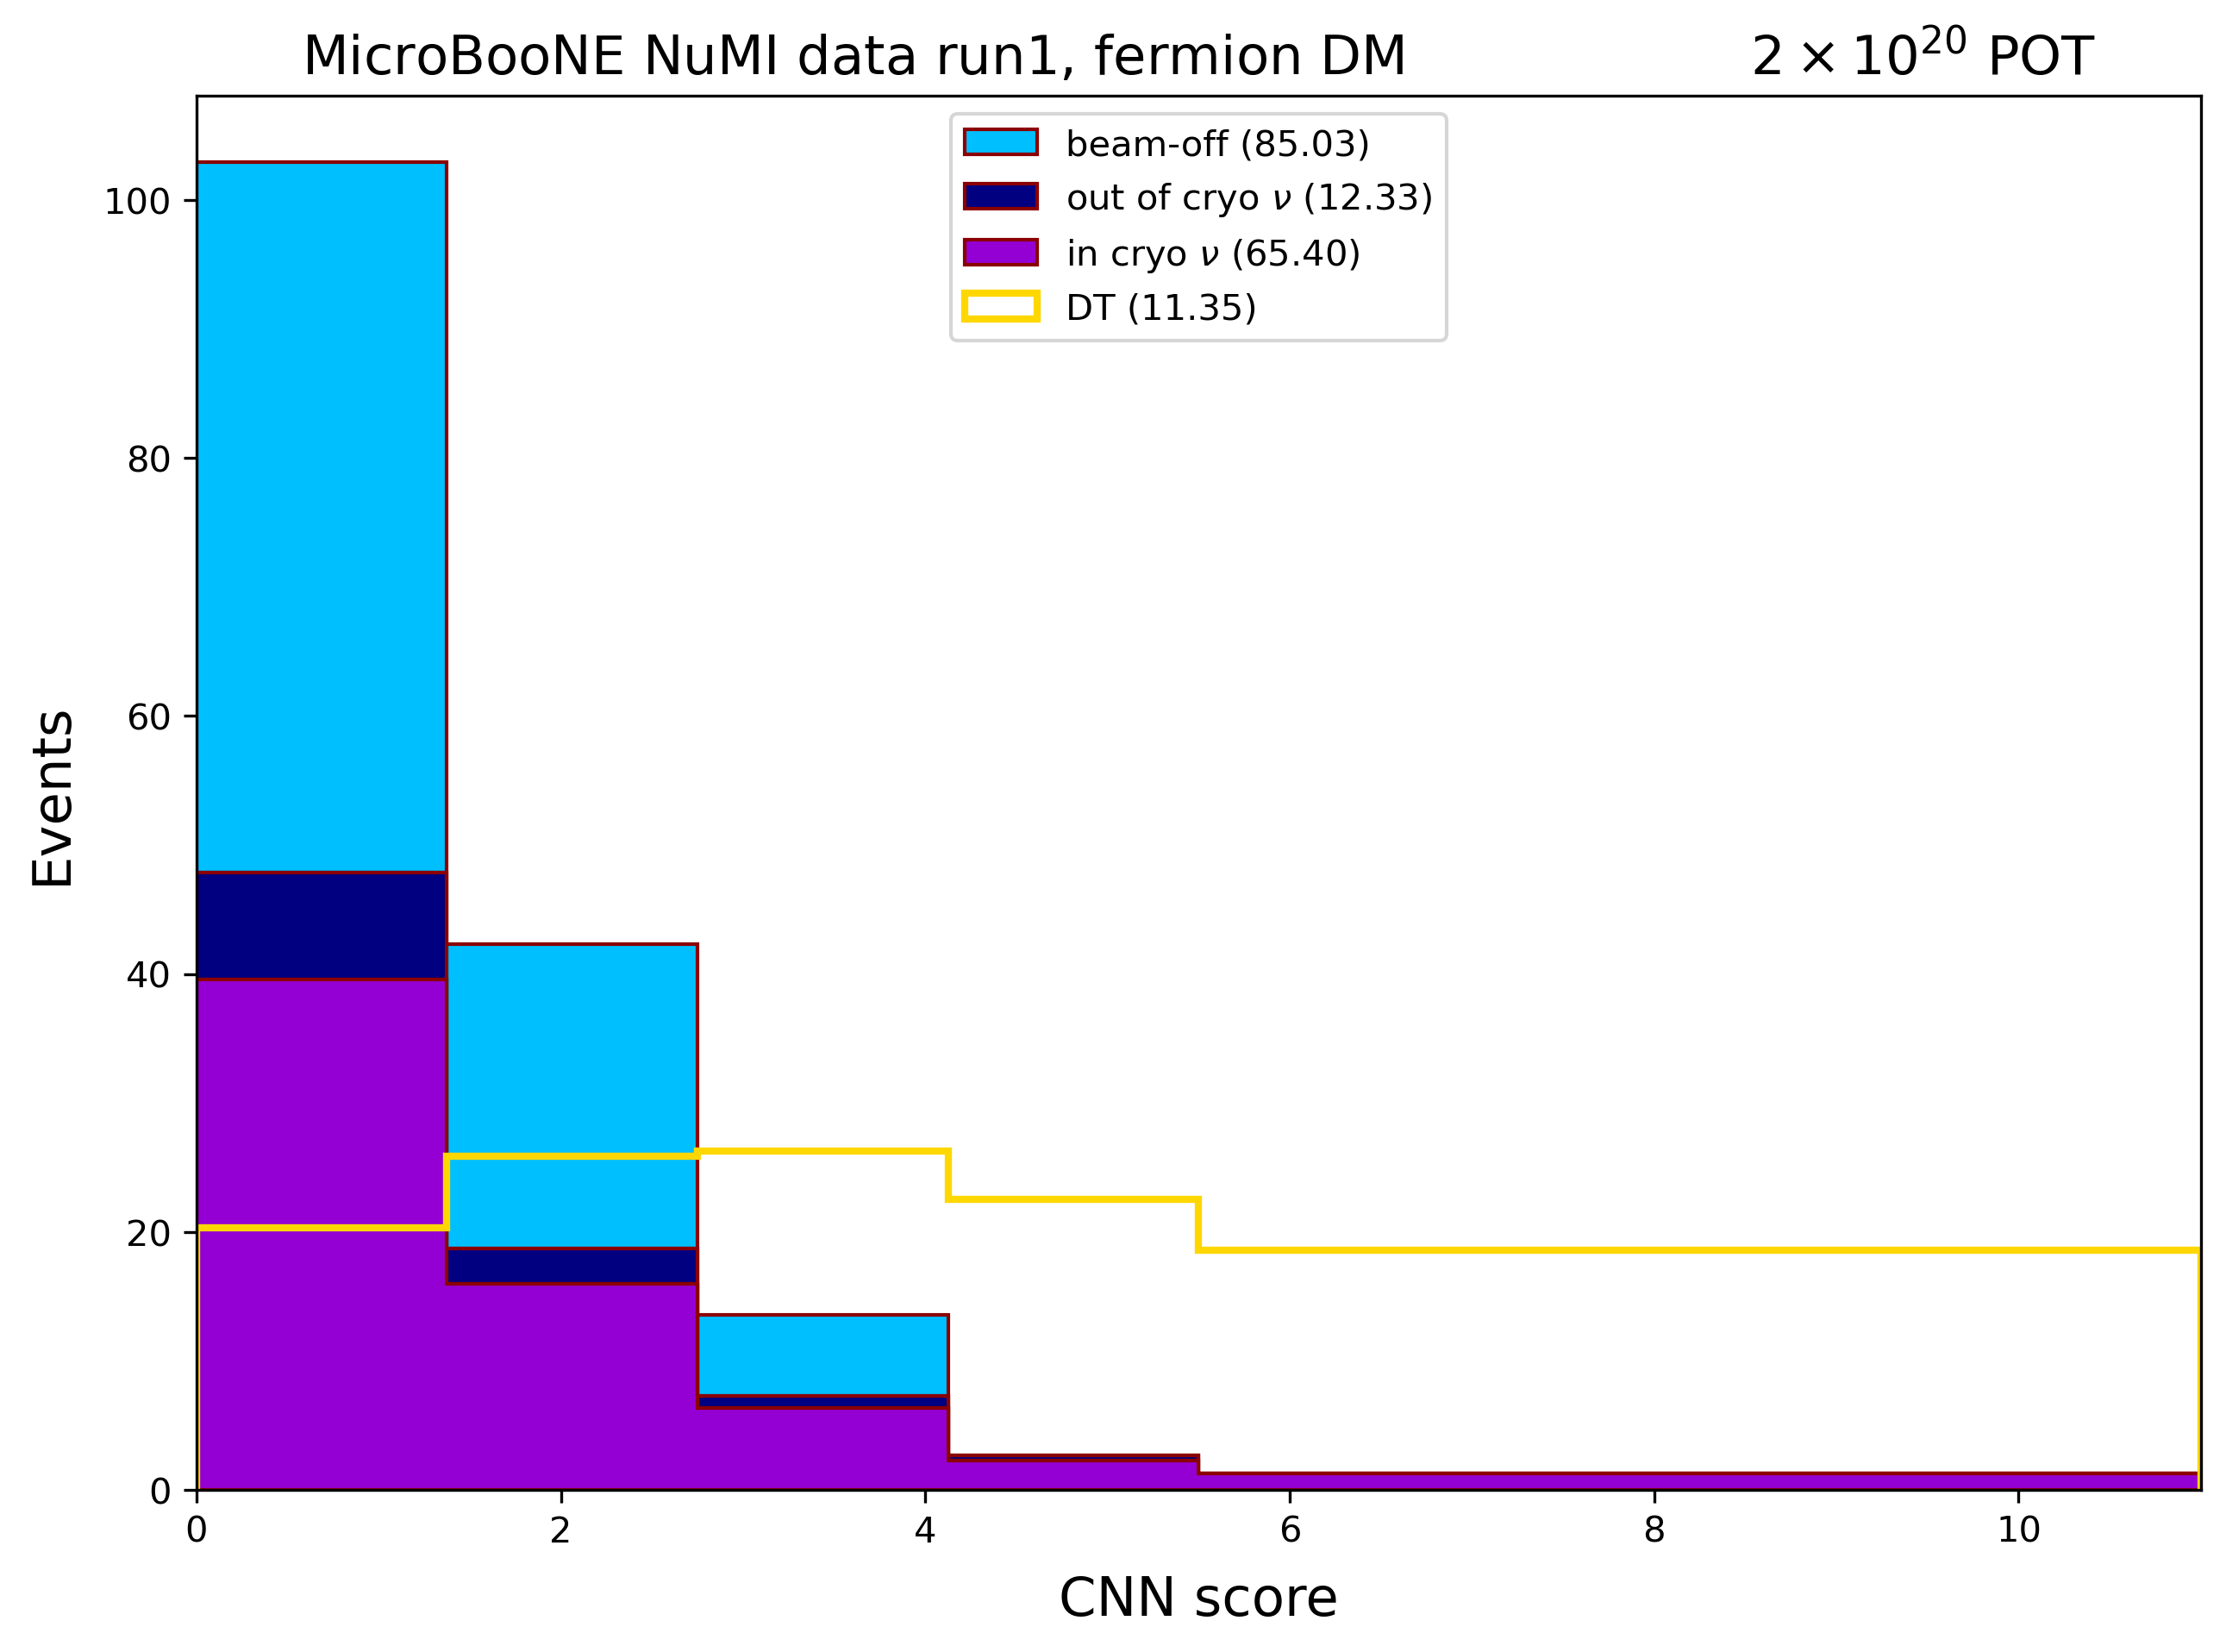

In [5]:
df_signal = filter_df(df_signal)
df_nu = filter_df(df_nu)
df_dirt = filter_df(df_dirt)
df_offbeam = filter_df(df_offbeam)


df_signal['signal_score'] = logit_transform(df_signal['signal_score'])
df_nu['signal_score'] = logit_transform(df_nu['signal_score'])
df_dirt['signal_score'] = logit_transform(df_dirt['signal_score'])
df_offbeam['signal_score'] = logit_transform(df_offbeam['signal_score'])



my_custom_bins = [ 0., 1.375, 2.75, 4.125, 5.5, 11.] # Last four bins merged bc of low stats 
variable = 'signal_score'
plot_xrange = (0.,11.)


(counts_signal, bins_signal) = np.histogram(df_signal[variable], bins = my_custom_bins)
(counts_nu, bins_nu) = np.histogram(df_nu[variable], bins = my_custom_bins, weights = df_nu['weight'])
(counts_dirt, bins_dirt) = np.histogram(df_dirt[variable], bins = my_custom_bins, weights = df_dirt['weight'])
(counts_offbeam, bins_offbeam) = np.histogram(df_offbeam[variable], bins = my_custom_bins)

print("Showing results for: " + run)
print("Number of dark tridents M_A="+str(mass)+" :" + str(np.sum(counts_signal)*signal_scaling))
print("Number of neutrinos: " + str(np.sum(counts_nu)*nu_scaling))
print("Number of dirt: " + str(np.sum(counts_dirt)*dirt_scaling))
print("Number of beam-off: " + str(np.sum(counts_offbeam)*offbeam_scaling))

# Set plot specs with patches!!!

dt_legend = r'DT ({:.2f})'.format(np.sum(counts_signal)*signal_scaling)
nu_legend = r'in cryo $\nu$ ({:.2f})'.format(np.sum(counts_nu)*nu_scaling)
dirt_legend = r'out of cryo $\nu$ ({:.2f})'.format(np.sum(counts_dirt)*dirt_scaling)
beamoff_legend = r'beam-off ({:.2f})'.format(np.sum(counts_offbeam)*offbeam_scaling)

stacked_colors = ["darkviolet","navy","deepskyblue"]
stacked_legend = [nu_legend, dirt_legend, beamoff_legend]
stacked_bins = [bins_nu[:-1], bins_dirt[:-1], bins_offbeam[:-1]]
stacked_list = [counts_nu*nu_scaling, counts_dirt*dirt_scaling, counts_offbeam*offbeam_scaling ]
plt.figure(figsize=(10,7),dpi=300)
plt.hist(stacked_bins, bins = bins_nu, weights = stacked_list, histtype='stepfilled',stacked=True, color = stacked_colors, edgecolor="darkred", label = stacked_legend)
plt.hist(bins_signal[:-1], bins = bins_signal,weights=counts_signal*signal_scaling*10, histtype='step',label=dt_legend ,fill=False, edgecolor='gold', linewidth='2.')
plt.legend(loc="upper center",fontsize=10)
plt.title(r'MicroBooNE NuMI data' + ' ' + run + ', ' + dm_type + ' DM' + pot_label ,fontsize=15)
plt.xlim(plot_xrange)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel(r'CNN score',fontsize=15,labelpad=7)
plt.ylabel("Events",fontsize=15, labelpad=7)
#plt.yscale('log')
#plt.ylim(10.,150)
plt.xlim(plot_xrange)
plt.savefig(plots_dir + dm_type + "_CNN_logits_" + run + "_dist.png")

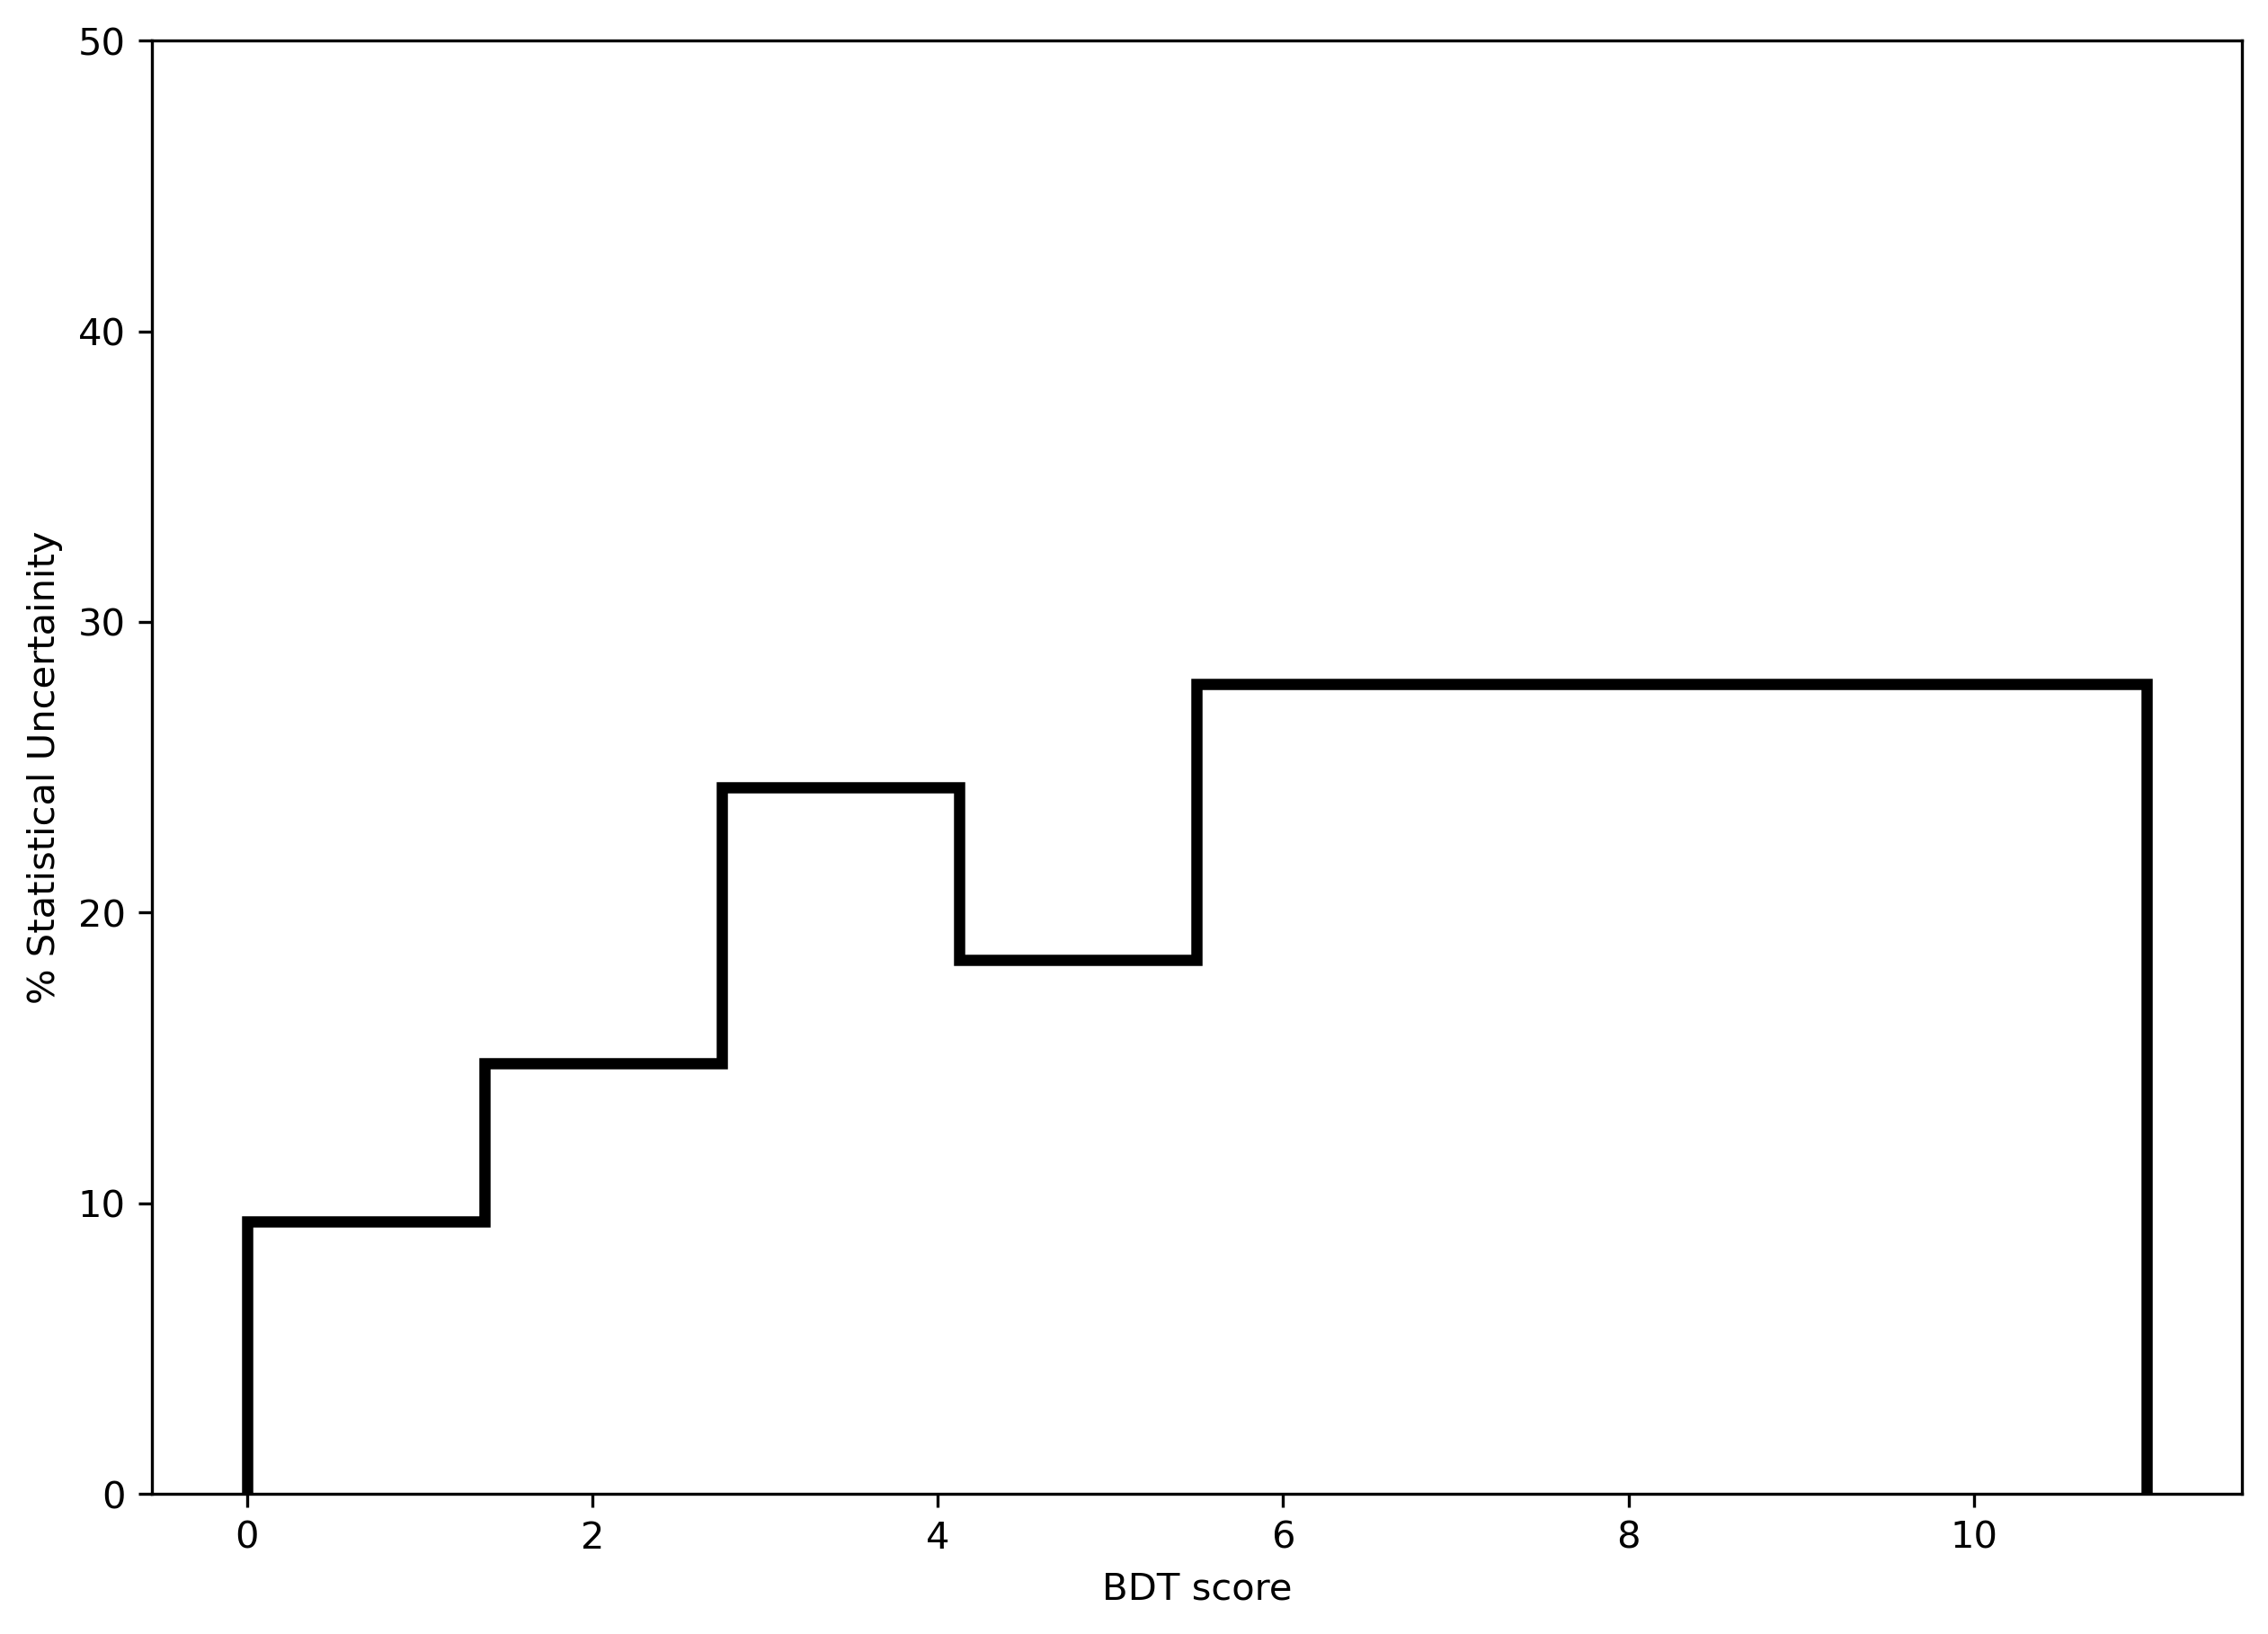

In [6]:
counts_bkg = counts_nu*nu_scaling + counts_dirt*dirt_scaling + counts_offbeam*offbeam_scaling

stats_nu = GetStatsUncert(df_nu, df_nu['weight']*nu_scaling)
stats_dirt = GetStatsUncert(df_dirt, df_dirt['weight']*dirt_scaling )
stats_offbeam = GetStatsUncert(df_offbeam, np.ones(len(df_offbeam))*offbeam_scaling)
stats_total = np.sqrt(stats_nu + stats_dirt + stats_offbeam)
stats_error = (stats_total)/(counts_bkg)

plt.figure(figsize=(10,7),dpi=300)
plt.hist(bins_signal[:-1], bins = bins_signal,weights=stats_error*100, color = "black", histtype="step",lw=3,linestyle="-")
plt.ylabel("% Statistical Uncertainity")
plt.xlabel("BDT score")
plt.ylim(0.,50)

bkg_file = u.recreate("background_hist_" + run + "_CNN.root")
bkg_file["background_hist"] = (counts_bkg, bins_nu)